# LNOB analysis: Unemployment rate
## Setup

In [1]:
# Import libraries
import pathlib
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set font for plots
import matplotlib as mpl
# mpl.rcParams['hatch.linewidth'] = 1
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Verdana']

In [2]:
# Path to the data repo
data_repo = pathlib.Path('C:/Users/menatri/Documents/sdg-data-donnees-odd/')

# Find all the csv files in the data folder
csvfiles = (data_repo / 'data').glob('*.csv')
# Load all indicator data into a dict
data = {f.stem[10:]: pd.read_csv(f) for f in csvfiles}

In [3]:
# Check data
data['2-1-2']

,Year,Household food security status,Geography,Sex,Age group,Economic family type,Visible minority,Indigenous population,GeoCode,Value
0,2018,Food secure,Canada,Both sexes,NaN,All persons,NaN,NaN,NaN,83.2
1,2018,Food insecure,Canada,Both sexes,NaN,All persons,NaN,NaN,NaN,16.8
2,2018,"Food insecure, marginal",Canada,Both sexes,NaN,All persons,NaN,NaN,NaN,5.2
3,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.6
4,2018,"Food insecure, moderate",Canada,Both sexes,NaN,All persons,NaN,NaN,NaN,8.0
...,...,...,...,...,...,...,...,...,...,...
17369,2021,Food secure,Northwest Territories,NaN,NaN,NaN,NaN,NaN,61.0,77.8
17370,2021,Food secure,Nunavut,NaN,NaN,NaN,NaN,NaN,62.0,53.9
17371,2022,Food secure,Yukon,NaN,NaN,NaN,NaN,NaN,60.0,78.6
17372,2022,Food secure,Northwest Territories,NaN,NaN,NaN,NaN,NaN,61.0,72.4


In [4]:
# Get data for desired indicator
indicator_data = data['2-1-2']
indicator_data = indicator_data.loc[indicator_data['Household food security status'].isin(['Food insecure, moderate or severe', np.nan])].drop('Household food security status', axis=1).reset_index(drop=True)

# Get the minimum value for each year
mins = indicator_data.groupby(by='Year')['Value'].min()
# Get the maximum value for each year
maxs = indicator_data.groupby(by='Year')['Value'].max()

# Get list of disaggregation columns in the dataframe
non_disagg_cols = ['Year', 'Series', 'Units', 'GeoCode', 'Value', 'COMMENT_OBS', 'COMMENT_OBS_0', 'COMMENT_OBS_1', 'COMMENT_OBS_2', 'Progress']
disagg_cols = [col for col in indicator_data.columns if col not in non_disagg_cols]
# Get the headline data from the dataframe (rows for which all disaggregation columns are NA)
headline = indicator_data.loc[indicator_data[disagg_cols].isna().all(axis=1)]

# Get start year and latest year from headline data
start_year = headline['Year'].min()
latest_year = headline['Year'].max()

# Group indicator data by series
data_groupby_series = indicator_data.dropna(subset='Value').groupby(by=disagg_cols, dropna=False)
# Group indicator data by year
data_groupby_year = indicator_data.groupby(by='Year', dropna=False)

In [5]:
# Calculate progress since 2015 for each population group
def get_progress_calculation_components(group):
    start_year = group['Year'].min()
    latest_year = group['Year'].max()
    start_value = group.loc[group['Year'] == start_year, 'Value'].values[0]
    latest_value = group.loc[group['Year'] == latest_year, 'Value'].values[0]
    cagr = (latest_value/start_value)**(1/(latest_year-start_year)) - 1
    return pd.Series({
        'start_year': start_year,
        'latest_year': latest_year,
        'start_value': start_value,
        'latest_value': latest_value,
        'cagr': cagr
    })



progress_by_series = data_groupby_series.apply(get_progress_calculation_components, include_groups=False).reset_index()

# # Filter to keep only series starting in start year and ending in latest year
# progress_by_series = progress_by_series.loc[(progress_by_series['start_year'] == start_year) & (progress_by_series['latest_year'] == latest_year)]

# Sort dataframe by CAGR
progress_by_series.sort_values(by='cagr')

C:\Users\local_menatri\Temp\ipykernel_39060\2806598493.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  cagr = (latest_value/start_value)**(1/(latest_year-start_year)) - 1


,Geography,Sex,Age group,Economic family type,Visible minority,Indigenous population,start_year,latest_year,start_value,latest_value,cagr
485,Prince Edward Island,NaN,NaN,NaN,Visible minority population,NaN,2022.0,2023.0,32.4,15.6,-0.518519
530,Quebec,NaN,NaN,NaN,Other visible minority,NaN,2022.0,2023.0,28.3,14.6,-0.484099
129,British Columbia,NaN,NaN,NaN,Filipino,NaN,2022.0,2023.0,19.6,15.0,-0.234694
522,Quebec,Male,NaN,Persons in lone-parent families,NaN,NaN,2022.0,2023.0,24.0,21.6,-0.100000
499,Quebec,Both sexes,NaN,Persons in couple families with other relatives,NaN,NaN,2021.0,2022.0,8.0,7.2,-0.100000
...,...,...,...,...,...,...,...,...,...,...,...
204,Manitoba,Both sexes,NaN,Persons in other senior families,NaN,NaN,2020.0,2022.0,7.3,16.4,0.498858
108,British Columbia,Both sexes,NaN,Persons in other senior families,NaN,NaN,2021.0,2023.0,7.1,16.3,0.515181
133,British Columbia,NaN,NaN,NaN,South Asian,NaN,2020.0,2023.0,4.6,17.6,0.564054
130,British Columbia,NaN,NaN,NaN,Latin American,NaN,2022.0,2023.0,16.7,30.1,0.802395


## LNOB Gap Chart

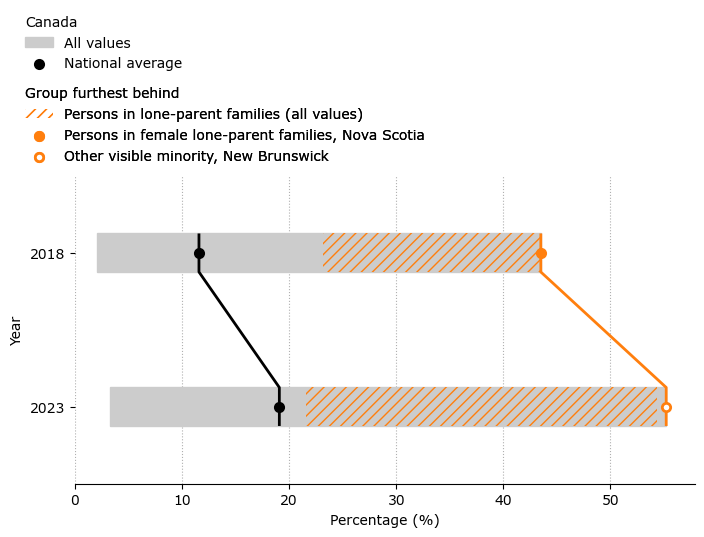

In [6]:
fig, ax = plt.subplots(figsize=(8,4))

# Set gray color used in chart
gray = '#CCCCCC'

# Get min, max, headline, and spread values for the start year and the latest year
start_max = maxs.iloc[0]
start_min = mins.iloc[0]
latest_max = maxs.iloc[-1]
latest_min = mins.iloc[-1]
headline_start = headline.Value.iloc[0]
headline_latest = headline.Value.iloc[-1]
start_spread = start_max - start_min
latest_spread = latest_max - latest_min

bar_width = 0.25

# Plot bar for start year at y=0
natl_range = ax.add_patch(plt.Rectangle((start_min, 0-bar_width/2), start_spread, bar_width, color=gray, zorder=3, label='All values'))
# Plot bar for latest year at y=1
ax.add_patch(plt.Rectangle((latest_min, 1-bar_width/2), latest_spread, bar_width, color=gray, zorder=3))

connector_ys = [0-bar_width/2, 0+bar_width/2, 1-bar_width/2, 1+bar_width/2]
# Add headline to plot
natl_avg = ax.scatter(headline.Value.iloc[[0,-1]], [0, 1], color='k', label='National average', lw=2, zorder=3)
ax.plot([headline_start, headline_start, headline_latest, headline_latest], connector_ys, 'k', lw=2, solid_capstyle='butt', zorder=3)
# Add headline to legend
legend1 = ax.legend(handles=[natl_range, natl_avg], title='Canada', alignment='left',
                        bbox_to_anchor=(-0.1, 1.3), loc='lower left', frameon=False)

# Highlight group furthest behind
# Add hatch area denoting Group furthest behind
# Persons in lone-parent families in start year
group = progress_by_series.loc[(progress_by_series['Economic family type'] == 'Persons in lone-parent families') & (progress_by_series['start_year'] == start_year)]
group_start_min = group['start_value'].min()
group_start_spread = group['start_value'].max() - group_start_min
grp_range = ax.add_patch(plt.Rectangle((group_start_min, 0-bar_width/2), group_start_spread, bar_width,
                           hatch='///', facecolor='None', edgecolor='tab:orange', lw=0, zorder=3, label='Persons in lone-parent families (all values)'))
# Person in lone-parent families in latest year
group = progress_by_series.loc[(progress_by_series['Economic family type'] == 'Persons in lone-parent families') & (progress_by_series['latest_year'] == latest_year)]
group_latest_min = group['latest_value'].min()
group_latest_spread = group['latest_value'].max() - group_latest_min
ax.add_patch(plt.Rectangle((group_latest_min, 1-bar_width/2), group_latest_spread, bar_width,
                           hatch='///', facecolor='None', edgecolor='tab:orange', lw=0, zorder=3))

# group = progress_by_series.loc[(progress_by_series['Economic family type'] == 'Persons in lone-parent families') & (progress_by_series['Sex'] == 'Female') & (progress_by_series['start_year'] == start_year)]
# group_start_min = group['start_value'].min()
# group_start_spread = group['start_value'].max() - group_start_min
# grp_range = ax.add_patch(plt.Rectangle((group_start_min, 0-bar_width/2), group_start_spread, bar_width,
#                            hatch='//', facecolor='None', edgecolor='tab:blue', lw=0, zorder=3, label='Other visible minority (all values)'))
# progress_by_series.loc[(progress_by_series['Economic family type'] == 'Persons in lone-parent families') & (progress_by_series['Sex'] == 'Female') & (progress_by_series['latest_year'] == latest_year)]
# group_latest_min = group['latest_value'].min()
# group_latest_spread = group['latest_value'].max() - group_latest_min
# ax.add_patch(plt.Rectangle((group_latest_min, 1-bar_width/2), group_latest_spread, bar_width,
#                            hatch='//', facecolor='None', edgecolor='tab:blue', lw=0, zorder=3))

# Add data points indicating the sub-group furthest behind
grp_worst0 = ax.scatter(start_max, 0, c='tab:orange', label='Persons in female lone-parent families, Nova Scotia', linewidth=2, zorder=4)
grp_worst1 = ax.scatter(latest_max, 1, facecolor='w', edgecolor='tab:orange', label='Other visible minority, New Brunswick', linewidth=2, zorder=5)
ax.plot([start_max, start_max, latest_max, latest_max], connector_ys, 'tab:orange', lw=2, solid_capstyle='butt', zorder=4)
# Add Group/sub-group(s) furthest behind to legend
legend2 = ax.legend(handles=[grp_range, grp_worst0, grp_worst1], title='Group furthest behind', alignment='left',
          bbox_to_anchor=(-0.1,1), loc='lower left', frameon=False)
fig.add_artist(legend1)
fig.add_artist(legend2)

# Graph formatting, axis labels, grid, etc.
ax.set_xlim(0,)
ax.set_ylim([1.5, -0.5])
ax.set_yticks([0,1], labels=[start_year, latest_year])
ax.set_xlabel('Percentage (%)')
ax.set_ylabel('Year')
ax.grid(linestyle=':', axis='x')
ax.spines[['top', 'right', 'left']].set_visible(False)

# # Save figure as png
# fig.savefig('lnob_food_insecurity.png', dpi=300, bbox_inches='tight')

## Other stuff
### Which series corresponds to the minimum value in each year?

In [7]:
# Identify population with the lowest value for each year
min_values = indicator_data.iloc[data_groupby_year['Value'].idxmin()] # dataframe containing only the minimum value for each year
# Get the unique series containing at least 1 min value
unique_series_min = min_values[disagg_cols].drop_duplicates()
# Inner merge to get all data for each series containing a minimum value
min_serieses = indicator_data.merge(unique_series_min, on=disagg_cols, how='inner')

In [8]:
# Identify population with the lowest value for each year
max_values = indicator_data.iloc[data_groupby_year['Value'].idxmax()] # dataframe containing only the maximum value for each year
# Get the unique series containing at least 1 max value
unique_series_max = max_values[disagg_cols].drop_duplicates()
# Inner merge to get all data for each series containing a maximum value
max_serieses = indicator_data.merge(unique_series_max, on=disagg_cols, how='inner')

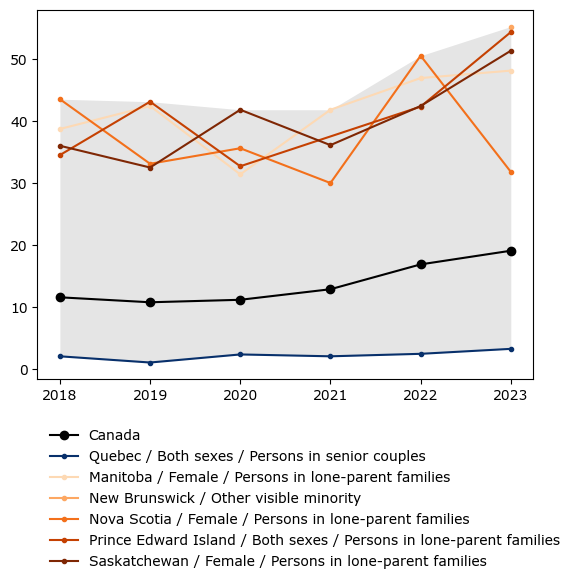

In [9]:
plt.fill_between(maxs.index, mins, maxs, color='k', alpha=0.1, linewidth=0)
plt.plot(headline.Year, headline.Value, 'ko-', label='Canada')

oranges = plt.cm.Oranges(np.linspace(0,1,len(unique_series_max)+1))
blues = plt.cm.Blues(np.linspace(0,1,len(unique_series_min)+1))

for i, series in enumerate(min_serieses.groupby(by=disagg_cols, dropna=False)):
    plt.plot(series[1].Year, series[1].Value, '.-', color=blues[i+1], label=' / '.join([x for x in series[0] if not pd.isna(x)]))
for i, series in enumerate(max_serieses.groupby(by=disagg_cols, dropna=False)):
    plt.plot(series[1].Year, series[1].Value, '.-', color=oranges[i+1], label=' / '.join([x for x in series[0] if not pd.isna(x)]))

plt.legend(bbox_to_anchor=(0,-0.1), loc='upper left', frameon=False)
plt.show()

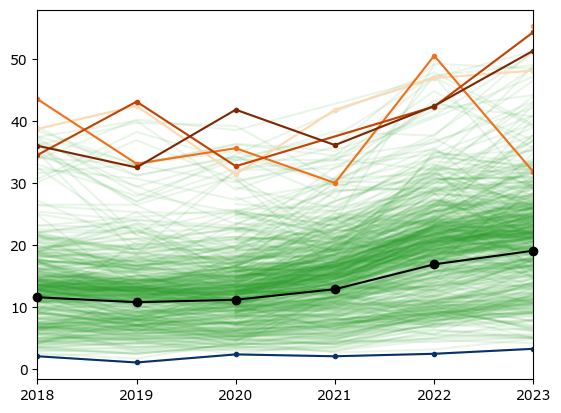

In [10]:
# Same graph as before but show all series in green with some transparency to better show distribution
for series in data_groupby_series:
    plt.plot(series[1].Year, series[1].Value, color='tab:green', alpha=0.1)

for i, series in enumerate(min_serieses.groupby(by=disagg_cols, dropna=False)):
    plt.plot(series[1].Year, series[1].Value, '.-', color=blues[i+1], label=' / '.join([x for x in series[0] if not pd.isna(x)]))
for i, series in enumerate(max_serieses.groupby(by=disagg_cols, dropna=False)):
    plt.plot(series[1].Year, series[1].Value, '.-', color=oranges[i+1], label=' / '.join([x for x in series[0] if not pd.isna(x)]))

plt.plot(headline.Year, headline.Value, 'ko-', label='Canada', clip_on=False)
plt.xlim(indicator_data.Year.min(), indicator_data.Year.max())
# plt.legend(frameon=False)
plt.show()

### Which groups are progressing the most/least?
I don't find this to be terribly informative on its own unfortunately. Often, those progressing the least (in a compound annual growth sense) are those that were already in an advantageous position...

It's much more useful in combination with the overall level - Is a group in the bottom 10% progressing more or less than the national trend? Beware: CAGR measures percent change, so a low group will have to have a much higher CAGR than the national CAGR to "catch up". Maybe the difference is more informative than the CAGR (if we ensure that the start year and latest year is the same everywhere).

In [11]:
# Filter to only look at the progress of series that start in the start year and end in the latest year, and find the 5 series with the lowest CAGR
worst_progress = progress_by_series.loc[(progress_by_series['start_year'] == start_year) & (progress_by_series['latest_year'] == latest_year)].nsmallest(5, columns=['cagr'])
worst_progress['rank'] = worst_progress['cagr'].rank(method='first')
worst_progress_serieses = worst_progress[disagg_cols+['rank']].merge(indicator_data, on=disagg_cols, how='inner')
worst_progress_serieses.dropna(subset='Value', inplace=True)
worst_progress

,Geography,Sex,Age group,Economic family type,Visible minority,Indigenous population,start_year,latest_year,start_value,latest_value,cagr,rank
515,Quebec,Female,NaN,Persons in lone-parent families,NaN,NaN,2018.0,2023.0,36.1,25.4,-0.067894,1.0
342,Nova Scotia,Female,NaN,Persons in lone-parent families,NaN,NaN,2018.0,2023.0,43.5,31.8,-0.060736,2.0
330,Nova Scotia,Both sexes,NaN,Persons in lone-parent families,NaN,NaN,2018.0,2023.0,39.0,29.0,-0.057532,3.0
502,Quebec,Both sexes,NaN,Persons in lone-parent families,NaN,NaN,2018.0,2023.0,32.5,24.6,-0.054176,4.0
483,Prince Edward Island,Male,NaN,Non-seniors not in an economic family,NaN,NaN,2018.0,2023.0,21.6,17.9,-0.036881,5.0


In [12]:
# Filter to only look at the progress of series that start in the start year and end in the latest year, and find the 5 series with the highest CAGR
best_progress = progress_by_series.loc[(progress_by_series['start_year'] == start_year) & (progress_by_series['latest_year'] == latest_year)].nlargest(5, columns=['cagr'])
best_progress['rank'] = best_progress['cagr'].rank(method='first', ascending=False)
best_progress_serieses = best_progress[disagg_cols+['rank']].merge(indicator_data, on=disagg_cols, how='inner')
best_progress_serieses.dropna(subset='Value', inplace=True)
best_progress

,Geography,Sex,Age group,Economic family type,Visible minority,Indigenous population,start_year,latest_year,start_value,latest_value,cagr,rank
551,Saskatchewan,Both sexes,NaN,Persons in other non-senior families,NaN,NaN,2018.0,2023.0,9.4,33.3,0.287844,1.0
285,Newfoundland and Labrador,Both sexes,NaN,Persons in couple families with children,NaN,NaN,2018.0,2023.0,8.8,25.1,0.233213,2.0
277,Newfoundland and Labrador,Both sexes,25 to 34 years,NaN,NaN,NaN,2018.0,2023.0,10.5,29.7,0.231157,3.0
547,Saskatchewan,Both sexes,NaN,Persons in couples,NaN,NaN,2018.0,2023.0,7.2,19.6,0.221757,4.0
563,Saskatchewan,Female,NaN,Seniors not in an economic family,NaN,NaN,2018.0,2023.0,4.5,12.0,0.216729,5.0


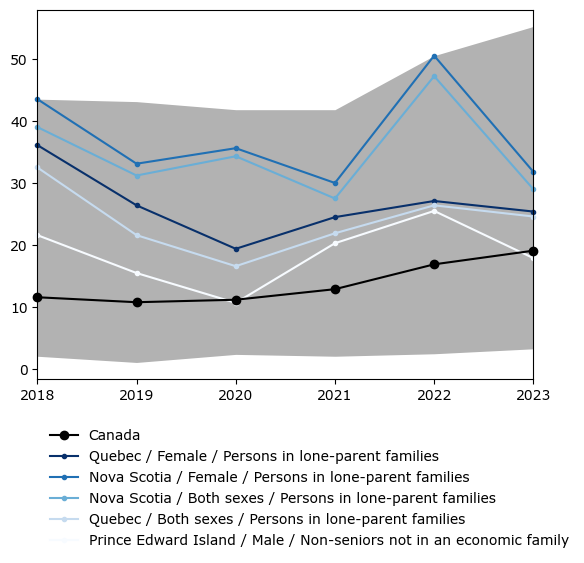

In [13]:
# Plot 5 series with lowest CAGR
blues = plt.cm.Blues(np.linspace(0,1,5))

plt.fill_between(maxs.index, mins, maxs, color='k', alpha=0.3, linewidth=0)
plt.plot(headline.Year, headline.Value, 'ko-', label='Canada', clip_on=False, zorder=3)

# for series in data_groupby_series:
#     plt.plot(series[1].Year, series[1].Value, color='tab:green', alpha=0.01)

for i, series in enumerate(worst_progress_serieses.groupby(by=['rank'])):
    plt.plot(series[1].Year, series[1].Value, '.-', color=blues[5-i-1], label=' / '.join([x for x in series[1][disagg_cols].iloc[0].values if not pd.isna(x)]), clip_on=False)

plt.xlim(indicator_data.Year.min(), indicator_data.Year.max())
plt.legend(bbox_to_anchor=(0,-0.1), loc='upper left', frameon=False)
plt.show()

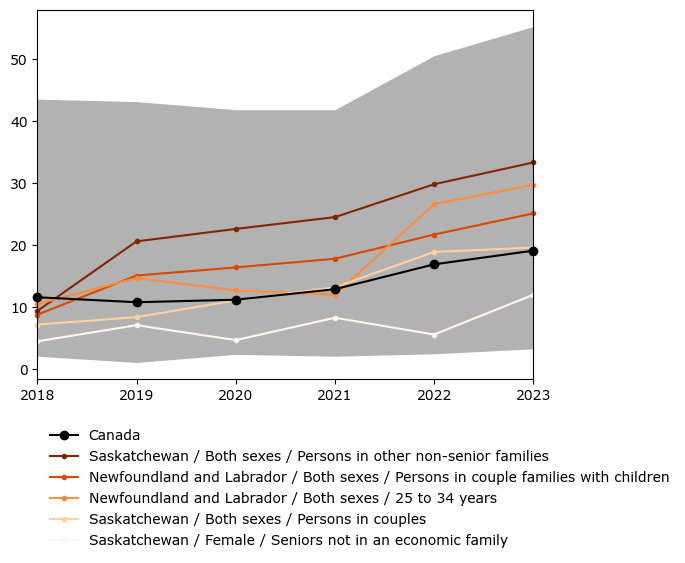

In [14]:
# Plot 5 series with highest CAGR
oranges = plt.cm.Oranges(np.linspace(0,1,5))

plt.fill_between(maxs.index, mins, maxs, color='k', alpha=0.3, linewidth=0)
plt.plot(headline.Year, headline.Value, 'ko-', label='Canada', clip_on=False, zorder=3)

# for series in data_groupby_series:
#     plt.plot(series[1].Year, series[1].Value, color='tab:green', alpha=0.01)

for i, series in enumerate(best_progress_serieses.groupby(by=['rank'])):
    plt.plot(series[1].Year, series[1].Value, '.-', color=oranges[5-i-1], label=' / '.join([x for x in series[1][disagg_cols].iloc[0].values if not pd.isna(x)]), clip_on=False)

plt.xlim(indicator_data.Year.min(), indicator_data.Year.max())
plt.legend(bbox_to_anchor=(0,-0.1), loc='upper left', frameon=False)
plt.show()

41.4 51.900000000000006
Spread has changed by 10.50%pts, or 25.36%
Headline has changed by 7.50%pts, or 64.66%


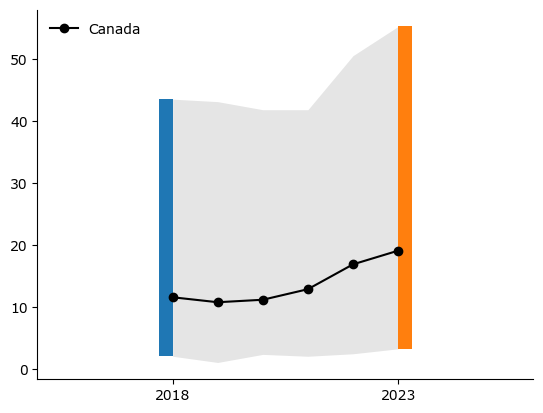

In [15]:
# Spread plot
spread = maxs - mins

start_year = mins.index[0]
latest_year = mins.index[-1]

start_min = mins.iloc[0]
start_max = maxs.iloc[0]
start_spread = spread.iloc[0]

latest_min = mins.iloc[-1]
latest_max = maxs.iloc[-1]
latest_spread = spread.iloc[-1]

fig, ax = plt.subplots()

plt.fill_between(maxs.index, mins, maxs, color='k', alpha=0.1, linewidth=0)


# Lines indicating spread at either end
ax.add_patch(plt.Rectangle((start_year, start_min), -0.3, start_spread, lw=0))
ax.add_patch(plt.Rectangle((latest_year, latest_min), 0.3, latest_spread, color='tab:orange', lw=0))

# Headline
ax.plot(headline.Year, headline.Value, 'ko-', label='Canada', clip_on=False, zorder=3)

# # Worst progress
# worst_progress_series = worst_progress_serieses.loc[worst_progress_serieses['rank'] == 1]
# ax.plot(worst_progress_series.Year, worst_progress_series.Value, '.-', label=' / '.join(worst_progress_series[disagg_cols].iloc[0].values), clip_on=False)

# # Most progress
# best_progress_series = best_progress_serieses.loc[best_progress_serieses['rank'] == 1]
# ax.plot(best_progress_series.Year, best_progress_series.Value, '.-', label=' / '.join(best_progress_series[disagg_cols].iloc[0].values), clip_on=False)

# # Lowest in start year
# min_series = indicator_data.merge(min_values[disagg_cols].iloc[0].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(min_series.Year, min_series.Value, '.-', label=' / '.join(min_series[disagg_cols].iloc[0].values), clip_on=False)

# # Lowest in latest year
# min_series = indicator_data.merge(min_values[disagg_cols].iloc[-1].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(min_series.Year, min_series.Value, '.-', label=' / '.join(min_series[disagg_cols].iloc[0].values), clip_on=False)

# # Highest in start year
# max_series = indicator_data.merge(max_values[disagg_cols].iloc[0].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(max_series.Year, max_series.Value, '.-', label=' / '.join(max_series[disagg_cols].iloc[0].values), clip_on=False)

# # Highest in latest year
# max_series = indicator_data.merge(max_values[disagg_cols].iloc[-1].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(max_series.Year, max_series.Value, '.-', label=' / '.join(max_series[disagg_cols].iloc[0].values), clip_on=False)

ax.set_xlim([start_year-3, latest_year+3])
ax.set_xticks([start_year, latest_year])
# ax.grid(linestyle=':')
ax.spines[['top', 'right']].set_visible(False)

plt.legend(frameon=False, loc='upper left')
# plt.legend(bbox_to_anchor=(0,-0.1), loc='upper left', frameon=False)

print(start_spread, latest_spread)

print(f'Spread has changed by {latest_spread-start_spread:.2f}%pts, or {(latest_spread-start_spread)/start_spread*100:.2f}%')
print(f'Headline has changed by {headline.Value.iloc[-1]-headline.Value.iloc[0]:.2f}%pts, or {(headline.Value.iloc[-1]-headline.Value.iloc[0])/headline.Value.iloc[0]*100:.2f}%')

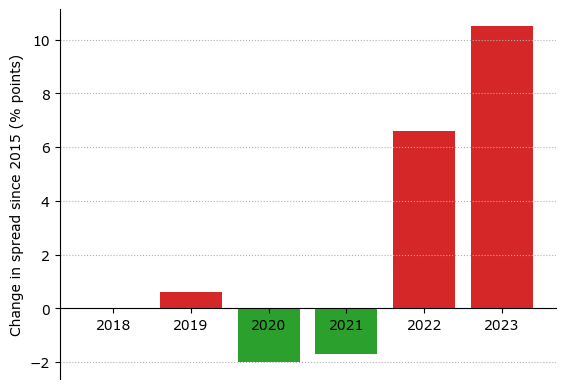

In [16]:
# Year-to-Year spread (in dollars)
# spread_percent = (spread - spread.iloc[0]) / spread.iloc[0] * 100

spread_diff = spread-spread.iloc[0]
spread_increasing = spread_diff.iloc[spread_diff.values > 0]
spread_decreasing = spread_diff.iloc[spread_diff.values <= 0]

fig, ax = plt.subplots()

ax.bar(spread_increasing.index, spread_increasing, color='tab:red')
ax.bar(spread_decreasing.index, spread_decreasing, color='tab:green')

ax.set_ylabel('Change in spread since 2015 (% points)')
ax.spines['bottom'].set_position('zero')
ax.spines[['top', 'right']].set_visible(False)
ax.grid(axis='y', linestyle=':')
plt.show()

### Bottom 10% analysis

Which categories appear more frequently in the bottom 10% compared to the rest of the population?

In [17]:
# Frequency analysis of categories appearing in bottom 10% over time
# Bottom 10% = Top 10% for this indicator because desired direction is down

start_year = 2020 # change start year for frequency analysis because most disagg categories only become available in 2020

# Filter out total/sub-total categories. Keep only "micro" level data
total_categories = {
    'Economic family type': ['All persons', 'Persons in economic families', 'Persons not in an economic family', 'Persons in senior families', 'Persons in non-senior families'],
    # 'Sex': ['Both sexes'],
    # 'Age group': ['18 to 64 years'],
    'Geography': ['Canada']
}
# Discard all rows with a total/sub-total category
micro_data = indicator_data.query(' and '.join([f"`{col}` not in {cats}" for col, cats in total_categories.items()]))
micro_data = micro_data.dropna(subset='Geography') # also drop the headline

# Get all unique (non-NA) categories in each column (used for filling the frequency dicts with zeros when the category does not appear in the segment)
full_index = {}
for col in disagg_cols:
    unique_cats = indicator_data[col].dropna().unique()
    full_index[col] = [cat for cat in unique_cats if cat not in total_categories.get(col, [])] # remove total/sub-total categories
    
# In 2020
# Calculate the 10th percentile threshold for the start year
percentile10_2015 = indicator_data.loc[indicator_data.Year == start_year, 'Value'].quantile(0.9)
# Filter the dataframe for the data in the bottom 10% in the start year
bottom10percent_2015 = indicator_data.loc[(indicator_data.Year == start_year) & (indicator_data.Value >= percentile10_2015)]
# Dict of the frequency (normalized count) of each category in the bottom 10% in the start year (include categories that do not appear with frequency = 0)
freq2015 = {col: bottom10percent_2015[col].value_counts(normalize=True).reindex(full_index[col], fill_value=0)*100 for col in disagg_cols}

# In 2023
# Calculate the 10th percentile threshold for the latest year
percentile10_2024 = indicator_data.loc[indicator_data.Year == latest_year, 'Value'].quantile(0.9)
# Filter the dataframe for the data in the bottom 10% in the latest year
bottom10percent_2024 = indicator_data.loc[(indicator_data.Year == latest_year) & (indicator_data.Value >= percentile10_2024)]
# Dict of the frequency (normalized count) of each category in the bottom 10% in the latest year (include categories that do not appear with frequency = 0)
freq2024 = {col: bottom10percent_2024[col].value_counts(normalize=True).reindex(full_index[col], fill_value=0)*100 for col in disagg_cols}

# Dict of the change in the appearance frequency of categories in the latest year compared to the start year
freqdiff = {col: (freq2024[col] - freq2015[col]).sort_values() for col in disagg_cols}

In [18]:
# Frequency analysis of categories appearing in the bottom 10% vs others
# Should we compare bottom 10% to top 90% or full dataset?
# In 2020
# Filter the dataframe for the rest of the population in the start year
top90percent_2015 = indicator_data.loc[(indicator_data.Year == start_year) & (indicator_data.Value < percentile10_2015)]
# Dict of the frequency (normalized count) of each category in the rest of the population in the start year (include categories that do not appear with frequency = 0)
freq_top2015 = {col: top90percent_2015[col].value_counts(normalize=True).reindex(full_index[col], fill_value=0)*100 for col in disagg_cols}

# Dict of difference in frequencies between bottom 10% and rest of population in the start year
freqdiff2015 = {col: (freq2015[col] - freq_top2015[col]).sort_values() for col in disagg_cols}

# In 2023
# Filter the dataframe for the rest of the population in the latest year
top90percent_2024 = indicator_data.loc[(indicator_data.Year == latest_year) & (indicator_data.Value < percentile10_2024)]
# Dict of the frequency (normalized count) of each category in the rest of the population in the latest year (include categories that do not appear with frequency = 0)
freq_top2024 = {col: top90percent_2024[col].value_counts(normalize=True).reindex(full_index[col], fill_value=0)*100 for col in disagg_cols}

# Dict of difference in frequencies between bottom 10% and rest of population in the latest year
freqdiff2024 = {col: (freq2024[col] - freq_top2024[col]).sort_values() for col in disagg_cols}

# categories to discard when plotting below (because they are total/sub-total categories that don't offer much information)
discard_categories = ['All persons', 'Both sexes', 'Canada']

In [19]:
def freqdiffplot(freqdiff, data=indicator_data, disagg_cols=disagg_cols, discard_categories=[], cmap=plt.cm.tab10, title=None, xlabel=None, xlim=None, pos=True, labelsize=None):
    '''
    Bar chart that plots categorical frequency.
    Arguments:
    freqdiff: dict. Dictionary containing the frequency of the each category.
    data: DataFrame. The dataframe upon which the categorical frequency analysis is based (used to determine the mapping between groups).
    disagg_cols: list. List of disaggregation column names.
    discard_categories: list. Remove these categories from the final figure.
    cmap: Categorical colour map instance. Categories belonging to a same disaggregation group will be the same colour.
    title: str. Figure title
    xlabel: str. X-axis label
    xlim: list or tuple. Limits for the x-axis
    pos: bool. True (default) = Only plot categories whose appearance frequency is > 0. False = plot all categories.
    labelsize: float. Set the fontsize for the category name labels along the y-axis.
    '''
    # Flatten dictionary of frequency differences
    freqdiff_flat = pd.concat([freqdiff[col] for col in disagg_cols]).dropna().sort_values()
    # Create dictionary that lists the group name for every category
    disagg_groups = {}
    for col in disagg_cols:
        categories = data[col].dropna().unique()
        for category in categories:
            disagg_groups[category] = col

    cmap_groups = {col: i for i, col in enumerate(disagg_cols)}

    # Discard meaningless categories from plot
    if discard_categories:
        freqdiff_flat = freqdiff_flat[~freqdiff_flat.index.isin(discard_categories)]
    
    fig, ax = plt.subplots()
    
    if title:
        ax.set_title(title)

    mask = [True]*len(freqdiff_flat)
    if pos is True:
        mask = freqdiff_flat > 0

    ax.barh(freqdiff_flat[mask].index, freqdiff_flat[mask], color=cmap([cmap_groups[disagg_groups[c]] for c in freqdiff_flat[mask].index]))

    if xlim:
        ax.set_xlim(xlim)
    if xlabel:
        ax.set_xlabel(xlabel)
    if labelsize:
        ax.tick_params(axis='y', labelsize=labelsize)
    ax.spines['left'].set_position('zero')
    ax.spines[['top', 'bottom', 'right']].set_visible(False)
    ax.grid(axis='x', linestyle=':')

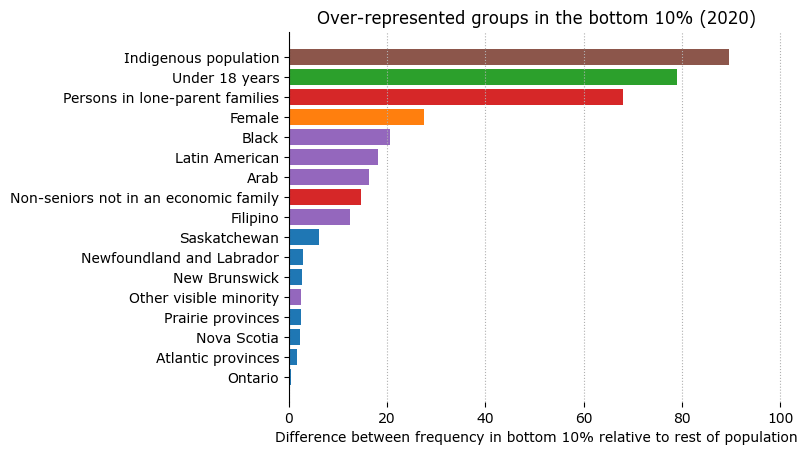

In [20]:
freqdiffplot(freqdiff2015, 
             # discard_categories=discard_categories,
             title=f'Over-represented groups in the bottom 10% ({start_year})', 
             xlabel='Difference between frequency in bottom 10% relative to rest of population', 
             xlim=(0,101)
            )

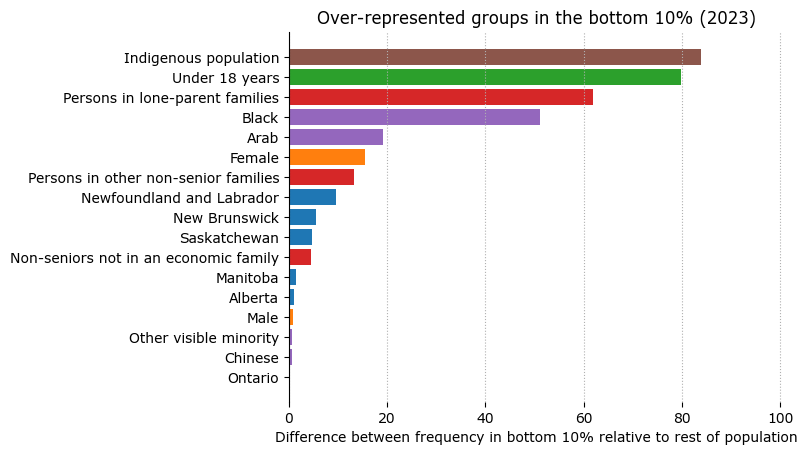

In [21]:
freqdiffplot(freqdiff2024,
             # discard_categories=discard_categories,
             title=f'Over-represented groups in the bottom 10% ({latest_year})',
             xlabel='Difference between frequency in bottom 10% relative to rest of population',
             xlim=(0,101)
            )

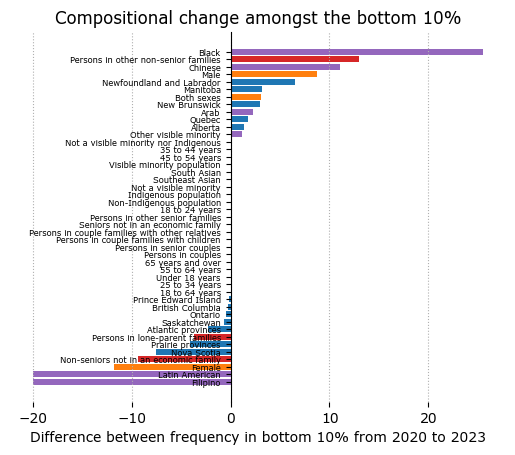

In [22]:
freqdiffplot(freqdiff,
             # discard_categories=discard_categories,
             title='Compositional change amongst the bottom 10%',
             xlabel=f'Difference between frequency in bottom 10% from {start_year} to {latest_year}',
             pos=False, labelsize=6)

### At the highest level, which categories are left behind?

Analyzing the progress and overall level of the main categories...

In [23]:
progress_headline = get_progress_calculation_components(headline)

def get_total_category_rows(df, total_categories={}):
    progress_by_category = pd.DataFrame([])
    for k in total_categories.keys():
        # Find all unique categories in the column
        categories =df[k].unique()
        # Remove the total category from the list of unique categories
        categories = categories[categories != total_categories[k]]
        for c in categories:
            query_str = f'`{k}` == "{c}"'
            for kk in total_categories.keys():
                if kk != k:
                    query_str += f' and `{kk}` == "{total_categories[kk]}"'
            # progress_by_category[c] = progress_by_series.query(query_str)
            progress_by_category = pd.concat([progress_by_category, df.query(query_str)])
    return progress_by_category

total_categories_fam = {
    'Economic family type': 'All persons',
    'Sex': 'Both sexes',
    'Geography': 'Canada'
}

progress_by_category_fam = get_total_category_rows(progress_by_series, total_categories_fam)

progress_by_category_age = progress_by_series.loc[(progress_by_series['Geography'] == 'Canada') & (progress_by_series['Sex'] == 'Both sexes') & ~progress_by_series['Age group'].isna()]

progress_by_category_vismin = progress_by_series.loc[(progress_by_series['Geography'] == 'Canada') & ~progress_by_series['Visible minority'].isna()]

progress_by_category_indigenous = progress_by_series.loc[(progress_by_series['Geography'] == 'Canada') & ~progress_by_series['Indigenous population'].isna()]

progress_by_category = pd.concat([progress_by_category_fam, progress_by_category_age, progress_by_category_vismin, progress_by_category_indigenous])
progress_by_category

,Geography,Sex,Age group,Economic family type,Visible minority,Indigenous population,start_year,latest_year,start_value,latest_value,cagr
147,Canada,Both sexes,NaN,Non-seniors not in an economic family,NaN,NaN,2018.0,2023.0,18.9,25.8,0.064220
148,Canada,Both sexes,NaN,Persons in couple families with children,NaN,NaN,2018.0,2023.0,11.2,20.5,0.128515
149,Canada,Both sexes,NaN,Persons in couple families with other relatives,NaN,NaN,2018.0,2023.0,8.2,15.0,0.128380
150,Canada,Both sexes,NaN,Persons in couples,NaN,NaN,2018.0,2023.0,7.6,15.0,0.145659
151,Canada,Both sexes,NaN,Persons in economic families,NaN,NaN,2018.0,2023.0,10.9,18.7,0.113994
152,Canada,Both sexes,NaN,Persons in lone-parent families,NaN,NaN,2018.0,2023.0,32.3,39.5,0.041068
153,Canada,Both sexes,NaN,Persons in non-senior families,NaN,NaN,2018.0,2023.0,12.0,20.6,0.114133
154,Canada,Both sexes,NaN,Persons in other non-senior families,NaN,NaN,2018.0,2023.0,15.8,25.1,0.096992
156,Canada,Both sexes,NaN,Persons in senior couples,NaN,NaN,2018.0,2023.0,2.9,5.7,0.144710
157,Canada,Both sexes,NaN,Persons in senior families,NaN,NaN,2018.0,2023.0,4.5,9.2,0.153759


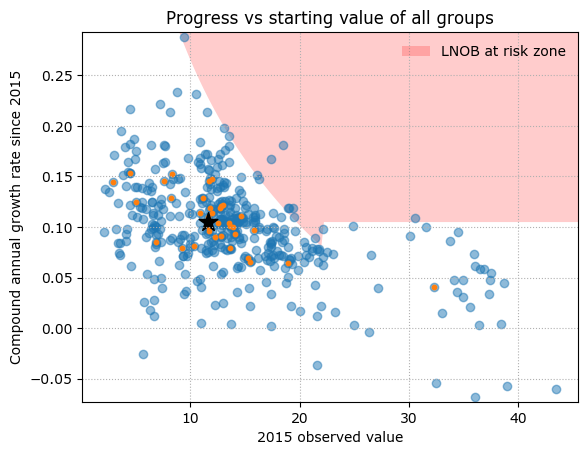

In [24]:
# LNOB at risk
# Which groups are at risk of being left behind?

# Filtering out LOTS of groups that only appear as of 2020
start_year = 2018
progress_by_series_filtered = progress_by_series.loc[(progress_by_series['start_year'] == start_year) & (progress_by_series['latest_year'] == latest_year)]
progress_by_category_filtered = progress_by_category.loc[(progress_by_category['start_year'] == start_year) & (progress_by_category['latest_year'] == latest_year)]

# Create figure
# TO DO: fix LNOB at risk zone (math error is giving sharp point bit that shouldn't be there)
fig, ax = plt.subplots()

ax.set_title('Progress vs starting value of all groups')

# Identify at risk zone for being left behind...
# ... starting value in bottom 10% AND worse progress than national average; OR
# ... low enough rate of progress to fall into current bottom 10% given the initial starting value
def risklimit(x, bottom10_initial=percentile10_2015, bottom10_latest=percentile10_2024, cagr_avg=progress_headline.cagr, t=9):
    if x >= bottom10_initial:
        return cagr_avg
    else:
        return (bottom10_latest/x)**(1/t)-1
x = np.linspace(mins.iloc[0]-2,maxs.iloc[0]+2,200)
ax.fill_between(x, [risklimit(xi, t=2023-2018) for xi in x], progress_by_series_filtered.cagr.max()+1, color='r', alpha=0.2, lw=0, label='LNOB at risk zone')

ax.scatter(progress_by_series_filtered.start_value, progress_by_series_filtered.cagr, alpha=0.5)
ax.scatter(progress_by_category_filtered.start_value, progress_by_category_filtered.cagr, s=10)
# Add headline (not included in progress_by_series)
ax.scatter(progress_headline.start_value, progress_headline.cagr, marker='*', color='k', s=200)

ax.set_xlim(mins.iloc[0]-2, maxs.iloc[0]+2)
ax.set_ylim(progress_by_series_filtered.cagr.min()-0.005, progress_by_series_filtered.cagr.max()+0.005)
ax.set_xlabel('2015 observed value')
ax.set_ylabel('Compound annual growth rate since 2015')
ax.grid(linestyle=':')
ax.legend(frameon=False)

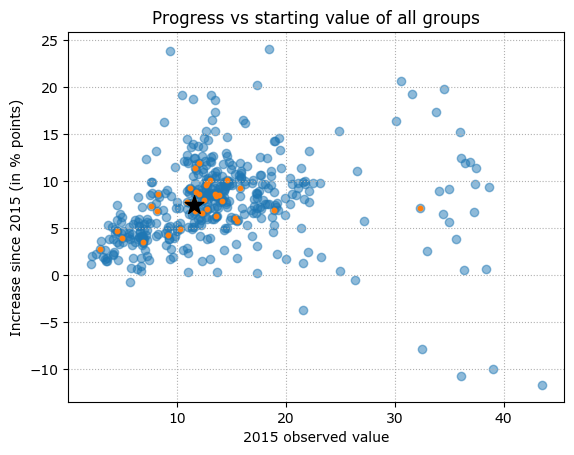

In [25]:
# LNOB at risk (linear difference rather than CAGR)
# TO DO: LNOB at risk zone for linear difference case

fig, ax = plt.subplots()

ax.set_title('Progress vs starting value of all groups')

ax.scatter(progress_by_series_filtered.start_value, progress_by_series_filtered.latest_value-progress_by_series_filtered.start_value, alpha=0.5)
ax.scatter(progress_by_category_filtered.start_value, progress_by_category_filtered.latest_value-progress_by_category_filtered.start_value, s=10)
ax.scatter(progress_headline.start_value, progress_headline.latest_value-progress_headline.start_value, marker='*', color='k', s=200)

ax.set_xlabel('2015 observed value')
ax.set_ylabel('Increase since 2015 (in % points)')
ax.grid(linestyle=':')
# ax.legend(frameon=False)

In [26]:
def get_series(row, disagg_cols=disagg_cols, total_categories=total_categories_fam):
    for index, value in row[disagg_cols].items():
        if not (total_categories.get(index) == value or pd.isna(value)):
            return value
    # for col in disagg_cols:
    #     if row[col] != total_categories[col]:
    #         return row[col]

# Get all data values from original df for the "macro" categories
merged_macro = indicator_data.merge(progress_by_category, on=disagg_cols, how='inner')
merged_macro['series'] = merged_macro.apply(get_series, axis=1)
merged_macro

,Year,Geography,Sex,Age group,Economic family type,Visible minority,Indigenous population,GeoCode,Value,start_year,latest_year,start_value,latest_value,cagr,series
0,2018,Canada,Both sexes,NaN,Persons in economic families,NaN,NaN,NaN,10.9,2018.0,2023.0,10.9,18.7,0.113994,Persons in economic families
1,2018,Canada,Both sexes,NaN,Persons in senior families,NaN,NaN,NaN,4.5,2018.0,2023.0,4.5,9.2,0.153759,Persons in senior families
2,2018,Canada,Both sexes,NaN,Persons in senior couples,NaN,NaN,NaN,2.9,2018.0,2023.0,2.9,5.7,0.144710,Persons in senior couples
3,2018,Canada,Both sexes,NaN,Persons in other senior families,NaN,NaN,NaN,8.3,2018.0,2023.0,8.3,16.9,0.152821,Persons in other senior families
4,2018,Canada,Both sexes,NaN,Persons in non-senior families,NaN,NaN,NaN,12.0,2018.0,2023.0,12.0,20.6,0.114133,Persons in non-senior families
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2023,Canada,NaN,NaN,NaN,Other visible minority,NaN,NaN,25.9,2020.0,2023.0,15.6,25.9,0.184109,Other visible minority
258,2023,Canada,NaN,NaN,NaN,Not a visible minority,NaN,NaN,16.6,2020.0,2023.0,9.9,16.6,0.188021,Not a visible minority
259,2023,Canada,NaN,NaN,NaN,NaN,Indigenous population,NaN,33.7,2020.0,2023.0,24.3,33.7,0.115170,Indigenous population
260,2023,Canada,NaN,NaN,NaN,NaN,Non-Indigenous population,NaN,18.7,2020.0,2023.0,10.8,18.7,0.200805,Non-Indigenous population


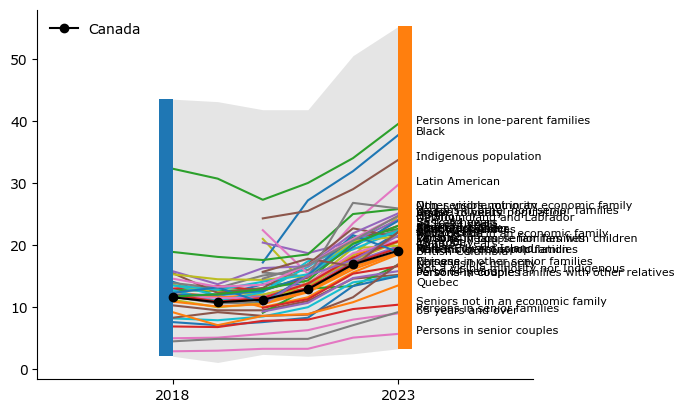

In [27]:
# Plot all macro categories

fig, ax = plt.subplots()

ax.fill_between(maxs.index, mins, maxs, color='k', alpha=0.1, linewidth=0)
# ax.fill_between(percentile10_by_year.index, mins, percentile10_by_year, color='k', alpha=0.1)
# ax.fill_between(percentile90_by_year.index, percentile90_by_year, maxs, color='k', alpha=0.1)

for series in merged_macro.groupby('series'):
    # ax.plot(series[1].Year, series[1].Value, linewidth=series[1].Population.iloc[0]/900, alpha=0.5, color='tab:blue', solid_capstyle='round')
    ax.plot(series[1].Year, series[1].Value)
    ax.text(latest_year+0.4, series[1]['latest_value'].iloc[0], series[1]['series'].iloc[0], fontsize=8)

# Lines indicating spread at either end
start_year = 2018
ax.add_patch(plt.Rectangle((start_year, start_min), -0.3, start_spread, lw=0, zorder=3))
ax.add_patch(plt.Rectangle((latest_year, latest_min), 0.3, latest_spread, color='tab:orange', lw=0, zorder=3))

# Headline
ax.plot(headline.Year, headline.Value, 'ko-', label='Canada', clip_on=False, zorder=3)

# # Worst progress
# worst_progress_series = worst_progress_serieses.loc[worst_progress_serieses['rank'] == 1]
# ax.plot(worst_progress_series.Year, worst_progress_series.Value, '.-', label=' / '.join(worst_progress_series[disagg_cols].iloc[0].values), clip_on=False)

# # Most progress
# best_progress_series = best_progress_serieses.loc[best_progress_serieses['rank'] == 1]
# ax.plot(best_progress_series.Year, best_progress_series.Value, '.-', label=' / '.join(best_progress_series[disagg_cols].iloc[0].values), clip_on=False)

# # Lowest in start year
# min_series = indicator_data.merge(min_values[disagg_cols].iloc[0].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(min_series.Year, min_series.Value, '.-', label=' / '.join(min_series[disagg_cols].iloc[0].values), clip_on=False)

# # Lowest in latest year
# min_series = indicator_data.merge(min_values[disagg_cols].iloc[-1].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(min_series.Year, min_series.Value, '.-', label=' / '.join(min_series[disagg_cols].iloc[0].values), clip_on=False)

# # Highest in start year
# max_series = indicator_data.merge(max_values[disagg_cols].iloc[0].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(max_series.Year, max_series.Value, '.-', label=' / '.join(max_series[disagg_cols].iloc[0].values), clip_on=False)

# # Highest in latest year
# max_series = indicator_data.merge(max_values[disagg_cols].iloc[-1].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(max_series.Year, max_series.Value, '.-', label=' / '.join(max_series[disagg_cols].iloc[0].values), clip_on=False)

ax.set_xlim([start_year-3, latest_year+3])
ax.set_xticks([start_year, latest_year])
# ax.grid(linestyle=':')
ax.spines[['top', 'right']].set_visible(False)

plt.legend(frameon=False, loc='upper left')
# plt.legend(bbox_to_anchor=(0,-0.1), loc='upper left', frameon=False)

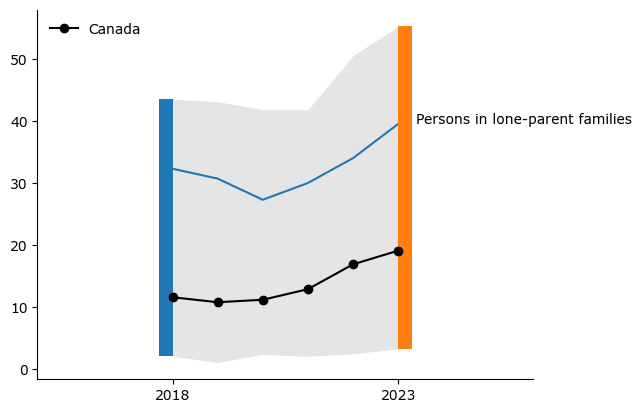

In [28]:
# Plot only worst macro category

fig, ax = plt.subplots()

ax.fill_between(maxs.index, mins, maxs, color='k', alpha=0.1, linewidth=0)
# ax.fill_between(percentile10_by_year.index, mins, percentile10_by_year, color='k', alpha=0.1)
# ax.fill_between(percentile90_by_year.index, percentile90_by_year, maxs, color='k', alpha=0.1)

# Plot group furthest behind (in 2015)
min_group = merged_macro.loc[(merged_macro.Year == 2018)].loc[merged_macro.start_value.idxmax()].series
min_series = merged_macro.loc[merged_macro.series == min_group]
ax.plot(min_series.Year, min_series.Value, zorder=3)
ax.text(2023+0.4, min_series['latest_value'].iloc[0], min_series['series'].iloc[0])

# for series in merged_macro.groupby('series'):
#     # ax.plot(series[1].Year, series[1].Value, linewidth=series[1].Population.iloc[0]/900, alpha=0.5, color='tab:blue', solid_capstyle='round')
#     ax.plot(series[1].Year, series[1].Value)
#     ax.text(2024+0.4, series[1]['latest_value'].iloc[0], series[1]['series'].iloc[0])



# Lines indicating spread at either end
ax.add_patch(plt.Rectangle((start_year, start_min), -0.3, start_spread, lw=0, zorder=3))
ax.add_patch(plt.Rectangle((latest_year, latest_min), 0.3, latest_spread, color='tab:orange', lw=0, zorder=3))

# Headline
ax.plot(headline.Year, headline.Value, 'ko-', label='Canada', clip_on=False, zorder=3)

# # Worst progress
# worst_progress_series = worst_progress_serieses.loc[worst_progress_serieses['rank'] == 1]
# ax.plot(worst_progress_series.Year, worst_progress_series.Value, '.-', label=' / '.join(worst_progress_series[disagg_cols].iloc[0].values), clip_on=False)

# # Most progress
# best_progress_series = best_progress_serieses.loc[best_progress_serieses['rank'] == 1]
# ax.plot(best_progress_series.Year, best_progress_series.Value, '.-', label=' / '.join(best_progress_series[disagg_cols].iloc[0].values), clip_on=False)

# # Lowest in start year
# min_series = indicator_data.merge(min_values[disagg_cols].iloc[0].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(min_series.Year, min_series.Value, '.-', label=' / '.join(min_series[disagg_cols].iloc[0].values), clip_on=False)

# # Lowest in latest year
# min_series = indicator_data.merge(min_values[disagg_cols].iloc[-1].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(min_series.Year, min_series.Value, '.-', label=' / '.join(min_series[disagg_cols].iloc[0].values), clip_on=False)

# # Highest in start year
# max_series = indicator_data.merge(max_values[disagg_cols].iloc[0].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(max_series.Year, max_series.Value, '.-', label=' / '.join(max_series[disagg_cols].iloc[0].values), clip_on=False)

# # Highest in latest year
# max_series = indicator_data.merge(max_values[disagg_cols].iloc[-1].to_frame().T, on=disagg_cols, how='inner').dropna(subset='Value')
# ax.plot(max_series.Year, max_series.Value, '.-', label=' / '.join(max_series[disagg_cols].iloc[0].values), clip_on=False)

ax.set_xlim([start_year-3, latest_year+3])
ax.set_xticks([start_year, latest_year])
# ax.grid(linestyle=':')
ax.spines[['top', 'right']].set_visible(False)

plt.legend(frameon=False, loc='upper left')
# plt.legend(bbox_to_anchor=(0,-0.1), loc='upper left', frameon=False)